# Constant level steam boiler

## General model description

In this notebook we develop a global naïve steam generation model that represents the evaporation in a constant level (i.e. same internal mass) boiler. Physics is uncomplete but anyways the model is useful in some practical scenarios. If willing to go deeper, one needs to account for water partial pressure in gas above liquid level and the volume of the fed system, and also gas-liquid phase equilibria calculation. Here we keep only the solution of heat equation assuming that above a certaing temperature $T_{b}$ all heat is used to produce phase change and. The following equation accounts for the derivative of temperature below $T_{b}$ and denotes the terms account for energy entering the system (in) and leaving the system (out):

$$
m c_{p}\dot{T} = 
    \big(u + g c_{p}T_{0}\big)_{in} - 
    \big(g L_{h} + h \left(T - T_{\infty}\right)\big)_{out}
$$

In this equation $m$ is the mass of water in the container, $c_{p}$ its specific heat in mass units, $T_{0}$ is water inlet temperature, $u$ the external power input, $g$ the mass flow rate of water feeding the system, $L_{h}$ is water latent heat at ebulition temperature and $T_{\infty}$ is the environment temperature so that $T_{\infty} \le T_{b}$.

## Formulation at constant level

Once $T$ reaches $T_{b}$, since it is a pure substance, phase change takes place at constant temperature. It is assumed that the rate of evaporation is compensated by an equivalent flow $g$ so that system is helt at constant level. Setting the left-hand side of the above equation to zero and solving for $g$ one produces:

$$
g = \frac{u - h \left(T - T_{\infty}\right)}{c_{p}T_{(0)} - L_{h}} = v M_{w}
\quad\implies\quad
v = \frac{1}{M_{w}}\frac{u - h \left(T - T_{\infty}\right)}{c_{p}T_{(0)} - L_{h}}
$$

For working with chemistry it is often use mole units thus here we convert the mass flow rate $g$ into a molar flow rate $v$ through the water molar mass $M_{w}$. Since for $T<T_{b}$ there will be no water flow in the system (assuming evaporation can be neglected), the flow term $g$ can be removed from temperature equation and the following system of equations models the problem:

\begin{align}
    m c_{p}\dot{T} & = H(T_{b} - T) \left[u - h \left(T - T_{\infty}\right)\right]
    \\[6pt]
    v              & = H(T - T_{b}) \left[
                         \frac{1}{M_{w}}
                         \frac{u - h \left(T - T_{\infty}\right)}{c_{p}T_{(0)} - L_{h}}
                       \right]
\end{align}

In the above equations we have introduced two Heaviside functions to enforce the domain of each equation, ensuring derivative is zero above $T_{b}$ and activating ebulition with rate $v$.

## Reworking for numerical representation

Equations can be further simplified by introducing the following reduced temperature transforms:

\begin{align}
    \theta     & = T - T_{\infty}\implies \dot{T} = \dot{\theta} \\[6pt]
    \theta_{b} & = T_{b} - T_{\infty}
\end{align}

One can also benefit from the terms representing thermal inertia in the systems for simplification:

\begin{align}
    c_{\theta} & = \big(m c_{p}\big)^{-1}                                \\[6pt]
    c_{v}      & = \big(M_{w}(c_{p}T_{(0)} - L_{h})\big)^{-1}
\end{align}

And the system of equations is reduced to:

\begin{align}
    \dot{\theta} & = H(\theta_{b} - \theta)c_{\theta}\left[u - h \theta\right]
    \\[6pt]
    v            & = H(\theta - \theta_{b})c_{v}\left[u - h \theta\right]
\end{align}

Evaporation rate $v$ can be inversed to find out the required power $\tilde{u}$ to produce a given rate of production of steam:

\begin{equation}
    \tilde{u} = h\theta + \frac{v}{c_{v}}
\end{equation}

## Problem parameters

There are four sets of parameters that arise from this this formulation: water physical constants (heat capacity, latent heat, molar mass, boiling temperature), boiler related dimensions (water mass, global heat transfer coefficient, implicitly - we discuss later - nominal power), environment characteristics (water inlet reference temperature, environment temperature), and process related parameters, as discussed in what follows.

### Physical constants

In [1]:
% Water molecular weight [kg/mol].
global WaterMolecularWeight = 0.018;

% Water boiling latent heat [J/kg].
global WaterBoilLatentHeat = 2256000;

% Water heat capacity [J/(kg.K)].
global WaterHeatCapacity = 4200;

% Water boiling temperature [K].
global WaterBoilingTemp = 373.15;

### Boiler related dimensions

In [2]:
% Boiler global heat transfer coefficient [W/K].
global ParamBoilerHtc = 21.0;

% Boiler water mass [kg].
global ParamBoilerMass = 6.0;

% Boiler nominal power [W].
global ParamBoilerPower = 6800;

### Environment characteristics

In [3]:
% Inlet water temperature [K].
global ParamTempRef = 273.15;

% Environment temperature [K].
global ParamTempEnv = 298.15;

### Process related parameters

This last set of parameters was added for practical purposes which are not dealt with by the problem equations. For instance, given flow measurement precision or simply pressure drop in the system, there might be a minimum flow rate for which the boiler could work, so we added `WalterMinimumOutput`. For quickly reaching boiling temperature, the boiler might enforce a fixed fraction of its nominal power if no steam is being produced and for safety reasons that might be below the maximum value, what can be controlled through `ParamBoilerPowerStart`.

In [4]:
% Water minumum output [mol/s].
global WaterMinimumOutput = 0.01;

% Boiler fraction of power to start [-].
global ParamBoilerPowerStart = 1.0;

## Auxiliary quantities

Now we define functions that produce quantities required by the main application program. To start with we compute the constant of inertia for ebulition $c_{v}$ as `ConstantCv` given by $c_{v}=\big(M_{w}(c_{p}T_{(0)} - L_{h})\big)^{-1}$.

In [5]:
global ConstantCv = (WaterMolecularWeight * (
    WaterBoilLatentHeat - WaterHeatCapacity * ParamTempRef))^(-1);

Following the trend we also compute $c_{\theta} = \big(m c_{p}\big)^{-1}$ and make it accessible through `ConstantTheta`. 

In [6]:
global ConstantTheta = (ParamBoilerMass * WaterHeatCapacity)^(-1);

Finally we also need to compute total capacity of steam generation rate. 

In [7]:
global BoilerSteamCap = ConstantCv * (ParamBoilerPower 
    - ParamBoilerHtc * (WaterBoilingTemp - ParamTempEnv))

Since we added the flag `ParamSteamFlowIsPower` we need to handle the case where a desired evaporation rate is supplied and then is converted to power or when the steam flow value is already in power units. This is done by `RequestedFlowToPower` which computes $\tilde{u} = h\theta + v/c_{v}$ when necessary.

In [8]:
function u = RequestedFlowToPower(theta, steamFlow)
    % Convert flow rate to power to feed boiler.
    global ParamBoilerHtc;
    global ConstantCv;

    u = ParamBoilerHtc * theta + steamFlow / ConstantCv;
end

Another function for the algebraic computation of boiler output flow rate $v=c_{v}\left[u - h \theta\right]$ is provided in `BoilerOutputFlow`.

In [9]:
function v = BoilerOutputFlow(theta, u)
    % Compute output from boiler in [mol/s].
    global ConstantCv;
    global ParamBoilerHtc;
    
    v = ConstantCv * (u - ParamBoilerHtc * theta);
end

The next function `ComposeCommand` is related to the process constraints we discussed above. First we check if power is supplied (or steam requested) and boiling temperature is not yet reached. In this case we use the allowed fraction of nominal power to quickly heat water with power `u` and steam output `v` equals zero. Otherwise we get the power and compute output. Remember that for practical reasons we might want the output to be forced to zero in below some required steam generation rate, what is also handled by a conditional evaluation.

In [10]:
function [u, v] = ComposeCommand(theta, steamFlow)
    % Convert flow rate to power and ensure management.
    global ParamTempEnv;
    global WaterBoilingTemp;
    global WaterMinimumOutput;
    global ParamBoilerPowerStart;
    global ParamBoilerPower;
    
    shouldHeatWater = steamFlow > 0;
    notYetBoiling = theta + ParamTempEnv < WaterBoilingTemp;

    if (notYetBoiling && shouldHeatWater)
        u = ParamBoilerPowerStart * ParamBoilerPower;
        v = 0.0;
    else
        u = RequestedFlowToPower(theta, steamFlow);
        u = max(0, min(u, ParamBoilerPower));
        v = BoilerOutputFlow(theta, u);

        if (v <= WaterMinimumOutput)
            u = 0;
            v = 0;
        end
    end
end

## Main model and integration

Finally we need to evaluate the temperature derivative $\dot{\theta} = c_{\theta}\left[u - h \theta\right]$ to be able to integrate the problem. If working in state space formulation this is generally done through an expression as $\dot{y}=Ay + Bu$, where the derivative of $y$ depends on a linear transformation of current state $Ay$ and on an exogenous effect $Bu$. Making an analogy to our equation, $A = - c_{\theta}h$ and $B = c_{\theta}$. This formalism is useful because now it is easy to modify this model for inclusion of, for instant, reactor balances.

In [11]:
function [A, B] = ComputeCoefficients(u, theta)
    % Compute state space matrices.
    global ParamBoilerHtc;
    global ParamTempEnv;
    global WaterBoilingTemp;
    global ConstantTheta;
    
    % TODO test if power is supplied too!
    boilerIsOn = u >= ParamBoilerHtc * theta;
    boilerBoils = theta + ParamTempEnv >= WaterBoilingTemp;

    if (boilerIsOn && boilerBoils)
        A = B = 0.0;
    else
        B = ConstantTheta;
        A = -B * ParamBoilerHtc;
    end
end

To be able to evaluate our system we create a function that computes time-evolution and provides us with a table of results containing the columns:

1. Physical time, in seconds,
1. Boiler temperature, in kelvin,
1. Required boiler power input, in watts,
1. Required boiler output, in moles per second,
1. Computed boiler output, in moles per second.

In [12]:
function sol = SimulateSystem(nSteps, timeStep, boilerTempIni, powerSupply)
    % Simulate system dynamics with provided actions.
    global ParamTempEnv;
    global BoilerSteamCap;
    
    sol = zeros(nSteps, 5);
    theta = boilerTempIni - ParamTempEnv;
    
    for t = 1:nSteps
        mv = powerSupply(t) * BoilerSteamCap;
        [u, v] = ComposeCommand(theta, mv);
        sol(t, 1:end) = [(t - 1) * timeStep theta u mv v];

        [A, B] = ComputeCoefficients(u, theta);
        theta = theta + timeStep * (A * theta + B * u);
    end
end

We anticipate our post-processing needs by providing a function compatible with the outputs of `SimulateSystem`, so that we can always have standardized results display.

In [13]:
graphics_toolkit("gnuplot");


The gnuplot graphics toolkit is not actively maintained and has a number
of limitations that are unlikely to be fixed.  Communication with gnuplot
uses a one-directional pipe and limited information is passed back to the
Octave interpreter so most changes made interactively in the plot window
will not be reflected in the graphics properties managed by Octave.  For
example, if the plot window is closed with a mouse click, Octave will not
be notified and will not update its internal list of open figure windows.
The qt toolkit is recommended instead.


In [14]:
function PlotResponse(sol)
    % PLOT RESPONSE
    %   Display integrated solution in time.
    global ParamTempEnv;
    global ParamBoilerPower;
    
    t = sol(:, 1);
    T = sol(:, 2) + ParamTempEnv;
    P = sol(:, 3) * 100 / ParamBoilerPower;
    U = sol(:, 4);
    V = sol(:, 5);
    
    figure;

    subplot(3, 1, 1);
    plot(t, T, 'k', 'linewidth', 4); hold on;
    grid on; set(gca, 'GridLineStyle', ':');
    xlabel('Time [s]'); ylabel('Temperature [K]');

    subplot(3, 1, 2);
    plot(t, U, 'g', 'linewidth', 4); hold on;
    plot(t, V, 'r', 'linewidth', 4); hold on;
    grid on; set(gca, 'GridLineStyle', ':');
    xlabel('Time [s]'); ylabel('Flow rate [mol/s]');
    h = legend({'SP ', 'PV '});  
    set(h, "fontsize", 6);
    
    subplot(3, 1, 3);
    plot(t, P, 'r', 'linewidth', 4); hold on;
    grid on; set(gca, 'GridLineStyle', ':');
    xlabel('Time [s]'); ylabel('Relative power [%]');
endfunction

## Application program

So let's make a simple simulation. Starting with a boiler at ambient temperature, we apply some series of predefined steam output requirements to see what kind of steam output we can expect. All the physical parameters related to this boiler were already defined.

In [15]:
% Size of time step [s]
timeStep = 1.0;

% Number of steps in simulation.
nSteps = 4000;

% Initial temperature [K].
boilerTempIni = 288.15;

% Input power to boiler [-].
powerSupply = zeros(nSteps, 1);

% Create step of commands [-].  
powerSupply(1:nSteps/4) = 0.8;
powerSupply(nSteps/2:3*nSteps/4) = 0.3;

% Run simulation.
sol = SimulateSystem(nSteps, timeStep, boilerTempIni, powerSupply);

Below in the post processing we see that when boiler is not producing steam but steam flow is requested it keeps power at 100%, falling back to requested output when boiling of water is achieved. Notice that in our power supply above we made a step of 0.8 (80%) and another of 0.3 (30%) of total generation capacity, but in terms of power that does not correspond to these values. This is normal, since the relative effect of heat losses is different under these conditions and more relevant at lower steam output request.

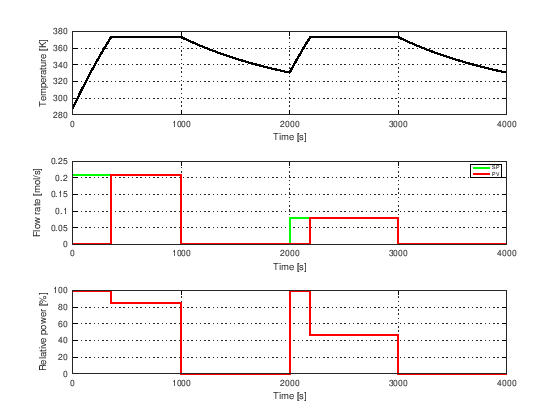

In [16]:
PlotResponse(sol)

## Next steps

Ok, this seems to work just fine, but implementing reusable code in a notebook is not good. To be able to test and expand this program an object-oriented implementation is provided under [note-203-ode-octave-steamer](./note-203-ode-octave-steamer) directory (same name as this notebook). Let's add this implementation and check how to use it.

In [17]:
addpath('octave')

To use all parameters by default (same as implemented above) and replicate the previous simulation simply instantiate the class `BoilerModel` and use its public methods. Notice here that only the simulation and plotting functions were made public, so the principle of abstraction is used, hiding what the end user does not need to know/modify.

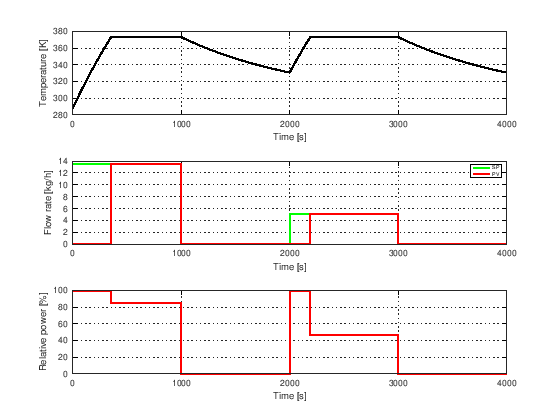

In [18]:
model = BoilerModel();
sol = model.SimulateSystem(nSteps, timeStep, boilerTempIni, powerSupply);
model.PlotResponse(sol)

You can also inspect the object properties by suppressing the semicolons.

In [19]:
model = BoilerModel()

model =

  BoilerModel object with properties:

             ParamBoilerHtc: [1x1 double]
            ParamBoilerMass: [1x1 double]
           ParamBoilerPower: [1x1 double]
      ParamBoilerPowerStart: [1x1 double]
               ParamTempEnv: [1x1 double]
               ParamTempRef: [1x1 double]
        WaterBoilLatentHeat: [1x1 double]
           WaterBoilingTemp: [1x1 double]
          WaterHeatCapacity: [1x1 double]
         WaterMinimumOutput: [1x1 double]
       WaterMolecularWeight: [1x1 double]



For instance, now to compute a smaller boiler with power 2800 W and mass of 2 kg, you simply do:

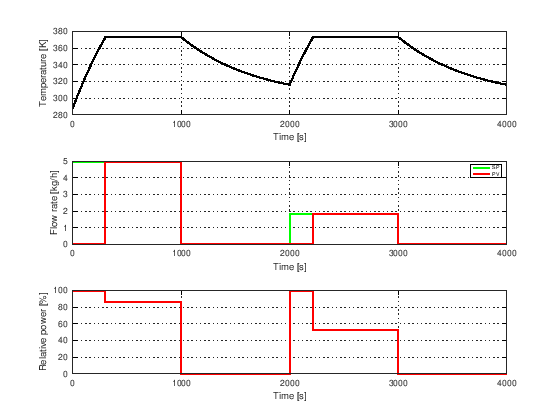

In [20]:
model = BoilerModel();
model.ParamBoilerPower = 2800;
model.ParamBoilerHtc = 12.0;
model.ParamBoilerMass = 2.0;

sol = model.SimulateSystem(nSteps, timeStep, boilerTempIni, powerSupply);
model.PlotResponse(sol)